# 1. Loading Data

In [1]:
import sys
import gc
import os
import warnings
import pickle
import statsmodels.api as sm
from pylab import rcParams
import time
from  datetime import datetime, timedelta

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

register_matplotlib_converters()
sns.set()

/usr/local/anaconda3/envs/data_science/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


## 1.1 Functions

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def display_missing(df):    
    for col in df.columns.tolist():  
        if df[col].isnull().sum() != 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    


## 1.2 Loading data grid

In [3]:
print('Loading the data...')
DATA_GRID_INPUT_DIR = '.'

data = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_model2.pkl')

Loading the data...


## 1.3 Init variables

In [4]:
h = 28 # Prediction horizon
max_lags = 366 # Max lags used
TRAINING_LAST_DAY_NUM = 1913 # Last day for training data
FIRST_PRED_DAY = datetime(2016,4, 25) # First prediction day
FIRST_LOADING_DAY = datetime(2013, 4,7) # First day for training
FIRST_LOADING_DAY_NUM = 800


## 1.4 Cuting the dataset

In [5]:
# Determine first needed day for training
# data = data.loc[data['date'] >= FIRST_LOADING_DAY] # So we will have space for lag and rolling features
# gc.collect()
# data.shape

# 2. Feature Engineering

## Creating features


In [6]:
def create_features(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag).astype(np.float16)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).astype(np.float16)

    
    
    date_features = {
        
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")


In [7]:
%%time

create_features(data)

CPU times: user 2min 4s, sys: 5.2 s, total: 2min 9s
Wall time: 2min 11s


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40718219 entries, 0 to 40718218
Data columns (total 31 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int8          
 3   store_id      int8          
 4   cat_id        int8          
 5   state_id      int8          
 6   d             object        
 7   sales         float16       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int8          
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int8          
 15  event_type_1  int8          
 16  event_name_2  int8          
 17  event_type_2  int8          
 18  snap_CA       float16       
 19  snap_TX       float16       
 20  snap_WI       float16       
 21  sell_price    float16       
 22  lag_7         float16       
 23  lag_28        float16       
 

In [9]:
data.dropna(inplace = True)
data.shape

(39041269, 31)

In [10]:
data

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,woy,quarter,mday
869062,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_405,0.0,2012-03-08,11206,4,6,3,2012,24,3,0,0,1.0,0.0,1.0,3.970703,0.0,0.0,0.000000,0.142822,0.214233,0.214233,10,1,8
869063,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_406,0.0,2012-03-09,11206,0,7,3,2012,0,0,0,0,1.0,1.0,1.0,3.970703,0.0,1.0,0.000000,0.142822,0.178589,0.250000,10,1,9
869069,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_405,1.0,2012-03-08,11206,4,6,3,2012,24,3,0,0,1.0,0.0,1.0,4.339844,3.0,2.0,1.857422,1.142578,1.392578,1.678711,10,1,8
869070,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_406,2.0,2012-03-09,11206,0,7,3,2012,0,0,0,0,1.0,1.0,1.0,4.339844,1.0,0.0,2.000000,1.000000,1.392578,1.607422,10,1,9
869076,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,d_405,0.0,2012-03-08,11206,4,6,3,2012,24,3,0,0,1.0,0.0,1.0,2.980469,0.0,0.0,0.000000,1.857422,0.750000,0.643066,10,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40718214,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.980469,0.0,1.0,1.000000,0.714355,0.928711,1.250000,16,2,24
40718215,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,0.0,2.0,0.856934,1.142578,1.036133,1.107422,16,2,23
40718216,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,4.0,0.714355,1.571289,1.036133,1.250000,16,2,24
40718217,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,2.285156,1.821289,1.786133,16,2,23


## Reduce mem usage of created features

In [11]:
data = reduce_mem_usage(data)

Mem. usage decreased to 2755.22 Mb (6.3% reduction)


# 3. Fit & Predict

In [12]:
print('Data usage: {} GB'.format(data.memory_usage().sum() / 10**9))
data.head()

Data usage: 2.889053906 GB


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,woy,quarter,mday
869062,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_405,0.0,2012-03-08,11206,4,6,3,2012,24,3,0,0,1.0,0.0,1.0,3.970703,0.0,0.0,0.000000,0.142822,0.214233,0.214233,10,1,8
869063,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_406,0.0,2012-03-09,11206,0,7,3,2012,0,0,0,0,1.0,1.0,1.0,3.970703,0.0,1.0,0.000000,0.142822,0.178589,0.250000,10,1,9
869069,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_405,1.0,2012-03-08,11206,4,6,3,2012,24,3,0,0,1.0,0.0,1.0,4.339844,3.0,2.0,1.857422,1.142578,1.392578,1.678711,10,1,8
869070,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_406,2.0,2012-03-09,11206,0,7,3,2012,0,0,0,0,1.0,1.0,1.0,4.339844,1.0,0.0,2.000000,1.000000,1.392578,1.607422,10,1,9
869076,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,d_405,0.0,2012-03-08,11206,4,6,3,2012,24,3,0,0,1.0,0.0,1.0,2.980469,0.0,0.0,0.000000,1.857422,0.750000,0.643066,10,1,8


In [13]:
train_end_dt = datetime(2016, 3, 27)
valid_end_dt = datetime(2016, 4, 24)

In [14]:
%%time

cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = data.columns[~data.columns.isin(useless_cols)]

# Splitting train and validation by date (28 days before prediction horizon)
# To drop na values only from training set
# train = data.loc[data.date <= train_end_dt].dropna()
# X_train = train[train_cols]
# y_train = train["sales"]
# %xdel train
# gc.collect()

# X_valid= data.loc[(data.date > train_end_dt) & (data.date <= valid_end_dt), train_cols]
# y_valid = data.loc[(data.date > train_end_dt) & (data.date <= valid_end_dt), "sales"]
# train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
# valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=cat_feats, free_raw_data=False)


# Random train-validation split
X_train = data[train_cols]
y_train = data["sales"]

np.random.seed(777)
valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
train_inds = np.setdiff1d(X_train.index.values, valid_inds)

train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], 
                         categorical_feature=cat_feats, free_raw_data=False)
valid_data = lgb.Dataset(X_train.loc[valid_inds], label = y_train.loc[valid_inds],
                        categorical_feature=cat_feats, free_raw_data=False)
del valid_inds, train_inds

del data, X_train, y_train 
gc.collect()


CPU times: user 14.2 s, sys: 2.33 s, total: 16.5 s
Wall time: 16.6 s


0

In [15]:

del X_train, y_train, X_valid, y_valid
gc.collect()
#fake_valid_inds = np.random.choice(len(X_train), 1000000)
#fake_valid_data = lgb.Dataset(X_train.iloc[fake_valid_inds], label = y_train.iloc[fake_valid_inds],categorical_feature=cat_feats,
#                             free_raw_data=False)   # This is just a subsample of the training set, not a real validation set !


NameError: name 'X_train' is not defined

In [26]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 2000,
    'num_leaves': 128,
    "min_data_in_leaf": 50
}

In [27]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [train_data, valid_data], early_stopping_rounds = 200, 
                  verbose_eval=50)



Training until validation scores don't improve for 200 rounds
[50]	training's rmse: 2.67967	valid_1's rmse: 2.68723
[100]	training's rmse: 2.43356	valid_1's rmse: 2.47778
[150]	training's rmse: 2.40473	valid_1's rmse: 2.46016
[200]	training's rmse: 2.38125	valid_1's rmse: 2.44431
[250]	training's rmse: 2.3625	valid_1's rmse: 2.43068
[300]	training's rmse: 2.34639	valid_1's rmse: 2.42068
[350]	training's rmse: 2.33202	valid_1's rmse: 2.40963
[400]	training's rmse: 2.3179	valid_1's rmse: 2.40129
[450]	training's rmse: 2.30486	valid_1's rmse: 2.39264
[500]	training's rmse: 2.29419	valid_1's rmse: 2.38779
[550]	training's rmse: 2.28319	valid_1's rmse: 2.38279
[600]	training's rmse: 2.2726	valid_1's rmse: 2.37598
[650]	training's rmse: 2.26156	valid_1's rmse: 2.36913
[700]	training's rmse: 2.2537	valid_1's rmse: 2.36445
[750]	training's rmse: 2.244	valid_1's rmse: 2.35969
[800]	training's rmse: 2.23685	valid_1's rmse: 2.35623
[850]	training's rmse: 2.22844	valid_1's rmse: 2.35259
[900]	trai

In [28]:
os.system('say "Training complete"')

0

In [29]:
m_lgb.save_model("model.lgb")

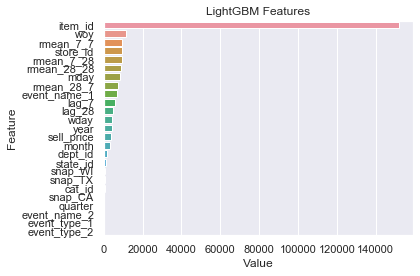

In [30]:
feature_importance = pd.DataFrame({"Value": m_lgb.feature_importance(), "Feature": m_lgb.feature_name()}) \
                    .sort_values(by="Value", ascending=False)

sns.barplot(x="Value", y="Feature", data=feature_importance)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [31]:
# Detection of features with zero-importance
# zero_features = list(feature_importance[feature_importance['Value'] == 0]['Feature'])
# print('\nThere are {} features with 0.0 importance'.format(len(zero_features)))
# print(zero_features)
# feature_importance

In [37]:
%%time 

tdata = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_test_model2.pkl')

CPU times: user 519 ms, sys: 492 ms, total: 1.01 s
Wall time: 1.58 s


In [ ]:
%%time

for i in range(0, 28):
    day = FIRST_PRED_DAY + timedelta(days=i)
    print(i, day)
    tst = tdata[(tdata.date >= day - timedelta(days=max_lags)) & (tdata.date <= day)].copy()
    create_features(tst)
    tst = tst.loc[tst.date == day , train_cols]
    tdata.loc[tdata.date == day, "sales"] = 1.03*m_lgb.predict(tst) 


0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00


In [ ]:
os.system('say "Prediction complete"')

In [ ]:
%%time

tdata_sub = tdata.loc[tdata.date >= FIRST_PRED_DAY, ["id", "sales"]].copy()
tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+ timedelta(days=h), "id"] = tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+timedelta(days=h), 
                                                                     "id"].str.replace("validation$", "evaluation")
tdata_sub["F"] = [f"F{rank}" for rank in tdata_sub.groupby("id")["id"].cumcount()+1]
tdata_sub = tdata_sub.set_index(["id", "F" ]).unstack()["sales"][[f"F{i}" for i in range(1,29)]].reset_index()
tdata_sub.fillna(0., inplace = True)

# kyakovlev magic trick
# for i in range(1,29):
#     tdata_sub['F'+str(i)] *= 1.03

tdata_sub.to_csv("submission.csv",index=False)
tdata_sub.shape
